<a href="https://colab.research.google.com/github/michelucci/MTL-OT-syntethic/blob/master/code/O2_prediction_model_Network_C_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code related to the paper on the prediction of $[O2]$ and $T$ at the same time with MTL - Network C

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

# Keras

from tensorflow.keras.models import Sequential

#from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tensorflow.keras import layers
import tensorflow.keras as keras

from keras.utils.vis_utils import plot_model

import tensorflow.keras.backend as K

from numpy import random

from scipy.interpolate import interp1d

from matplotlib.lines import Line2D

import seaborn as sns

Using TensorFlow backend.


# Read the files

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
file5 = pd.read_csv('/content/gdrive/My Drive/data/syntetic_data_5.csv')
file15 = pd.read_csv('/content/gdrive/My Drive/data/syntetic_data_15.csv')
file25 = pd.read_csv('/content/gdrive/My Drive/data/syntetic_data_25.csv')
file35 = pd.read_csv('/content/gdrive/My Drive/data/syntetic_data_35.csv')
file45 = pd.read_csv('/content/gdrive/My Drive/data/syntetic_data_45.csv')

In [0]:
df = pd.concat([file5, file15, file25, file35, file45])

In [6]:
target_df = df[['O2', 'T']]
target_df[['O2']] = target_df[['O2']]/110.0
target_df[['T']] = target_df[['T']]/45.0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [0]:
data_df = df.drop(['O2', 'T'], axis = 1)

Note that the values for $T$ are going from 0 to 1. To obtin the actual temperature in Celsius degrees, you need to multiply by $45$.

In [8]:
print(target_df['T'].unique())
print(target_df['T'].unique()*45)

[0.11111111 0.33333333 0.55555556 0.77777778 1.        ]
[ 5. 15. 25. 35. 45.]


## Dimensions

We have 25'000 observations.

In [9]:
data_df.shape

(25000, 16)

In [10]:
target_df.shape

(25000, 2)

In [11]:
target_df[target_df['T'] == 5./45.].shape

(5000, 2)

To check how many values we have for each temperature we can do easily with ```groupby()```.

In [12]:
target_df.groupby('T')['O2'].nunique()

T
0.111111    5000
0.333333    5000
0.555556    5000
0.777778    5000
1.000000    5000
Name: O2, dtype: int64

Each of the temperature has 5000 observations.

## Reset the index

In [0]:
data_df = data_df.reset_index(drop = True);
target_df = target_df.reset_index(drop = True);

The unique values of the temperature ($T$) are, as expected

In [14]:
np.unique(target_df['T'])*45

array([ 5., 15., 25., 35., 45.])

# Frequency values

In [0]:
wred = [3141.592653589793,
 4398.22971502571,
 6283.185307179586,
 9424.77796076938,
 12566.370614359172,
 18849.55592153876,
 25132.741228718343,
 31415.926535897932,
 37699.11184307752,
 43982.2971502571,
 50265.48245743669,
 56548.66776461628,
 62831.853071795864,
 75398.22368615503,
 87964.5943005142,
 100530.96491487337]

# Dataset split

In [0]:
np.random.seed(42)
rnd = np.random.rand(len(target_df)) < 0.8

In [0]:
data_train = data_df[rnd]
data_dev = data_df[~rnd]
targets_train = target_df[rnd]
targets_dev = target_df[~rnd]

In [18]:
print('Number of training data observations is ', data_train.shape)
print('Number of dev      data observations is ', data_dev.shape)

Number of training data observations is  (19983, 16)
Number of dev      data observations is  (5017, 16)


## Helper Functions

In [0]:
def MAE_T_list_generator(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks

In [0]:
def MAE_O2_list_generator(step, targets_dev, preds_df):
    breaks = np.arange(step,101.0, step)
    MAE_list = []
    MAE_xticks = []
    MAE_boxplot = []
    for O2_ in breaks:
        elmts = (targets_dev['O2'] < O2_/100.0) & (targets_dev['O2'] >= (O2_-step)/100.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(100*np.abs(tmp2_['O2'].values- tmp_['O2'].values))

        #print ("MAE for range [", int(O2_), ",", int(O2_-step), "] is", mae_)

        MAE_boxplot.append(list(100.0*np.abs(tmp_['O2'].values-tmp2_['O2'].values)))

        MAE_list.append(mae_)
        MAE_xticks.append("["+ str(int(O2_-step))+ ","+ str(int(O2_))+ "]")
    
    return MAE_boxplot, MAE_list, MAE_xticks

In [0]:
# Get predictions
def get_predictions(model, targets_dev, data_dev):
    preds = model.predict(data_dev)
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['O2', 'T']
    targets_dev_ = targets_dev.reset_index(drop = True)
    preds_df_ = preds_df.reset_index(drop = True)
    
    return targets_dev_, preds_df_

In [0]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 1000 == 0):
            print ("Just finished epoch", epoch)
            print (logs)
            return
        
class CustomCallbackProgress(keras.callbacks.Callback):
    
    def __init__(self, totalEpochs, step):
        self.step = 0
        self.totalEpochs = totalEpochs
        self.step = step
        
        
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 200 == 0):
            i = int(epoch / 200)
            
            if (i > 0):
                numberOfEquals = int(self.totalEpochs/200*i)
                percent = 100/(self.totalEpochs/200)*i
            else:
                numberOfEquals = 0
                percent = 0
                
                
            print ("\r[%-20s] %d%%" % ('='*i, percent), end='')
            
            if(percent == 100):
                print('')
        

In [0]:
def reset_keras():
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())

In [0]:
def average_runs(n_iter, model_):
    MAE_O2_boxplot_avg = [0]*9
    MAE_T_boxplot_avg = [0]*5

    for i in range(n_iter):
        print ("Training iteration ", i)
        
        model_.fit(data_train, targets_train, epochs=4001, batch_size=1000,verbose = 0,
             validation_data= (data_dev, targets_dev), callbacks = [CustomCallbackProgress(4000,200)])

        print("Getting predictions for iteration ",i)
        targets_dev_, preds_df_ = get_predictions(model_, targets_dev, data_dev)
        targets_train_, preds_train_ = get_predictions(model_, targets_train, data_train)

        print("Generating MAE lists for iteration ", i)
        MAE_boxplot_, MAE_list_, MAE_xticks_ = MAE_O2_list_generator(10.0, targets_dev_, preds_df_)
        MAE_T_boxplot_, MAE_T_list_, MAE_T_xticks_ = MAE_T_list_generator(targets_dev_, preds_df_)
        #MAE_boxplot_train_, MAE_list_train_, MAE_xticks_train_ = MAE_list_generator(10.0, targets_train_, preds_train_)

        for j in range(len(MAE_boxplot_)):
            MAE_O2_boxplot_avg[j] = MAE_O2_boxplot_avg[j] + np.array(MAE_boxplot_[j])/n_iter
            
        for j in range(len(MAE_T_boxplot_)):
            MAE_T_boxplot_avg[j] = MAE_T_boxplot_avg[j] + np.array(MAE_T_boxplot_[j])/n_iter

    return MAE_O2_boxplot_avg, MAE_T_boxplot_avg

In [0]:
def get_mae(MAE_boxplot_):
    flat_list = [item for sublist in MAE_boxplot_ for item in sublist]
    return np.mean(flat_list)

In [0]:
from time import sleep
for i in range(21):
    # the exact output you're looking for:
    print ("\r[%-20s] %d%%" % ('='*i, 5*i), end='')
    sleep(0.25)

[====================] 100%

# Random Seed to get reproducible results

In [0]:
K.clear_session()

from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

# Network C

In [0]:
class CustomCallback_(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 500 == 0):
            print ("Just finished epoch", epoch)
            print (logs)
            return

In [0]:
K.clear_session()

In [0]:
input_x = keras.layers.Input(shape = (16,))
lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
lay2 = layers.Dense(50, activation='sigmoid')(lay1)
lay3 = layers.Dense(50, activation='sigmoid')(lay2)
outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay3)

lay4 = layers.Dense(5, activation='sigmoid')(lay3)
lay5 = layers.Dense(5, activation='sigmoid')(lay4)
outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay5)


lay6 = layers.Dense(5, activation='sigmoid')(lay3)
lay7 = layers.Dense(5, activation='sigmoid')(lay6)
outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay7)

#model = Model(input_x, outl)

model4 = Model(
    inputs=input_x,
    outputs=[outboth, outo2, outT])

In [153]:
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 50)           850         input_3[0][0]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 50)           2550        dense_14[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 50)           2550        dense_15[0][0]                   
____________________________________________________________________________________________

In [0]:
losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
}

lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 1.0}

opt = Adam(lr=0.001)

model4.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
        metrics=["mae"])

In [0]:
targets_train_O2 = targets_train['O2']
targets_dev_O2 = targets_dev['O2']
targets_train_T = targets_train['T']
targets_dev_T = targets_dev['T']

### WORKING HERE

In [202]:
targets_train.shape

(19983, 2)

In [203]:
H = model4.fit(data_train,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=4000, batch_size = 19983,
        verbose=0, callbacks = [CustomCallback_()])

Just finished epoch 0
{'loss': 0.007154255174100399, 'both_output_loss': 0.0034267954, 'O2_output_loss': 0.00015382678, 'T_output_loss': 0.0053570825, 'both_output_mean_absolute_error': 0.04257509, 'O2_output_mean_absolute_error': 0.009555188, 'T_output_mean_absolute_error': 0.06298853, 'val_loss': 0.21634472906589508, 'val_both_output_loss': 0.07677096, 'val_O2_output_loss': 0.008926461, 'val_T_output_loss': 0.14868113, 'val_both_output_mean_absolute_error': 0.21068531, 'val_O2_output_mean_absolute_error': 0.08661953, 'val_T_output_mean_absolute_error': 0.33599362}
Just finished epoch 500
{'loss': 0.004790760111063719, 'both_output_loss': 0.002592304, 'O2_output_loss': 7.6976925e-05, 'T_output_loss': 0.0036281843, 'both_output_mean_absolute_error': 0.03537, 'O2_output_mean_absolute_error': 0.0058239666, 'T_output_mean_absolute_error': 0.05101775, 'val_loss': 0.004678466357290745, 'val_both_output_loss': 0.0025438275, 'val_O2_output_loss': 7.8603305e-05, 'val_T_output_loss': 0.00352230

In [0]:
(O2T, O2, T) = model4.predict(data_dev)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [0]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [0]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)

In [207]:
MAE_list_C

[0.35772180047195196,
 0.2602036405223689,
 0.34345415273366714,
 0.3413337305346389,
 0.43158246951271756,
 0.49294532759092363,
 0.38880789339368677,
 0.5664205828694714,
 1.0311002572428043,
 1.3150294521593924]

In [208]:
np.mean(MAE_list_C) 
# 64/32/32 -->
# 50       -->
# 80       -->

0.5528599307031623

<Figure size 432x288 with 0 Axes>

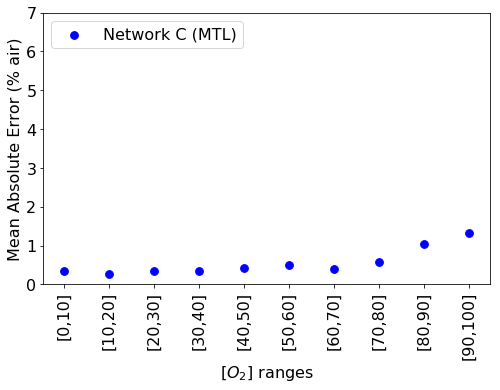

In [211]:
maxx = 4.0

plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(1, 1, 1)

#bp = ax.scatter(range(1,len(MAE_xticks50)+1),MAE_list50, s = 60, color = 'black', label = 'Network A (50/50/50)')
#bp = ax.scatter(range(1,len(MAE_xticks_MTL)+1),MAE_list_MTL, s = 60, color = 'red', label = 'Network B (MTL)')
bp = ax.scatter(range(1,len(MAE_xticks_C)+1),MAE_list_C, s = 60, color = 'blue', label = 'Network C (MTL)')
plt.ylim(0, 7)
plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')
#plt.grid()
plt.ylabel('Mean Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges', fontsize = 16)
plt.tick_params(labelsize=16)
plt.legend(loc = 'upper left', fontsize = 16)
#plt.xlim(0,9.5)


#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

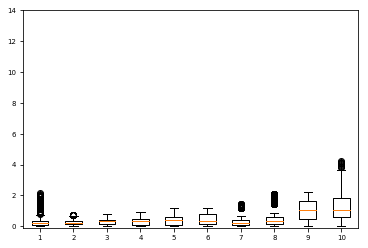

In [212]:
plt.boxplot(MAE_boxplot_C)
plt.ylim(-0.1, 14.0)
plt.show()

In [0]:
pdo2 = pd.DataFrame({'MAE_list': MAE_list_C, 'MAE_xticks': MAE_xticks_C, 'MAE_boxplot': MAE_boxplot_C})
pdT = pd.DataFrame({'MAET_list': MAET_list_C_MTL,'MAET_boxplot': MAET_boxplot_C_MTL, 'MAET_xticks':MAET_xticks_C_MTL})
pdo2.to_csv('/content/gdrive/My Drive/data/netc_O2.csv')
pdT.to_csv('/content/gdrive/My Drive/data/netc_T.csv')

In [214]:
np.mean(MAE_list_C)

0.5528599307031623

In [216]:
np.mean(MAET_list_C_MTL)

2.234788569224844

# VERSIONS

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf
